In [40]:
%matplotlib inline
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv3D, Conv3DTranspose,Conv2DTranspose
from keras.layers import LSTM, ConvLSTM2D, RepeatVector, TimeDistributed, Reshape, Flatten
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras import backend as K
from keras.utils import plot_model
K.image_data_format()
import json
from time import time
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
def load_data():

    with open('traindata_cost.json','r') as f:
        x_train = json.load(f)
        x_train = np.array([np.array([np.array(sr) for sr in r]) for r in x_train])
    with open('trainlabels_cost.json','r') as f:
        y_train = json.load(f)
    with open('testdata_cost.json','r') as f:
        x_test = json.load(f)
        x_test = np.array([np.array([np.array(sr) for sr in r]) for r in x_test])
    with open('testlabels_cost.json','r') as f:
        y_test = json.load(f)
    return x_train, y_train, x_test, y_test

def reframe_data(data, threedim=True, transpose=False, padding=True):
    #data : (-1,?,64)
    output = []
    dummy = [-1]*64
    
    for d in data:
        if padding:
            if len(d) < 1747:
                fill = 1747 - len(d)
                d = np.append(d,np.array([dummy]*fill),axis=0)
        if threedim:
            if transpose:
                #(8,8,?)
                output.append(d.T.reshape(8,8,-1))
            else:
                #(?,8,8)
                output.append(d.reshape(-1,8,8))

        else:
            if transpose:
                #(64,?)
                output.append(d.T)
            else:
                #(?,64) same as original data
                pass
    return np.array(output)
    

In [3]:
x_train, y_train, x_test, y_test = load_data()
x_train = reframe_data(x_train)
x_test = reframe_data(x_test)
print(x_train.shape, x_test.shape)

(6244, 1747, 8, 8) (1561, 1747, 8, 8)


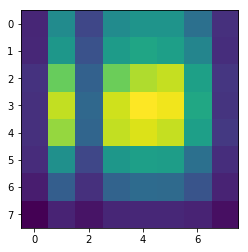

In [16]:
# np.random.shuffle(data)
# data = data / 255
# n = 1650
# train = data[:n]
# test = data[n:]
plt.imshow(x_train[0][1].reshape(8,8))

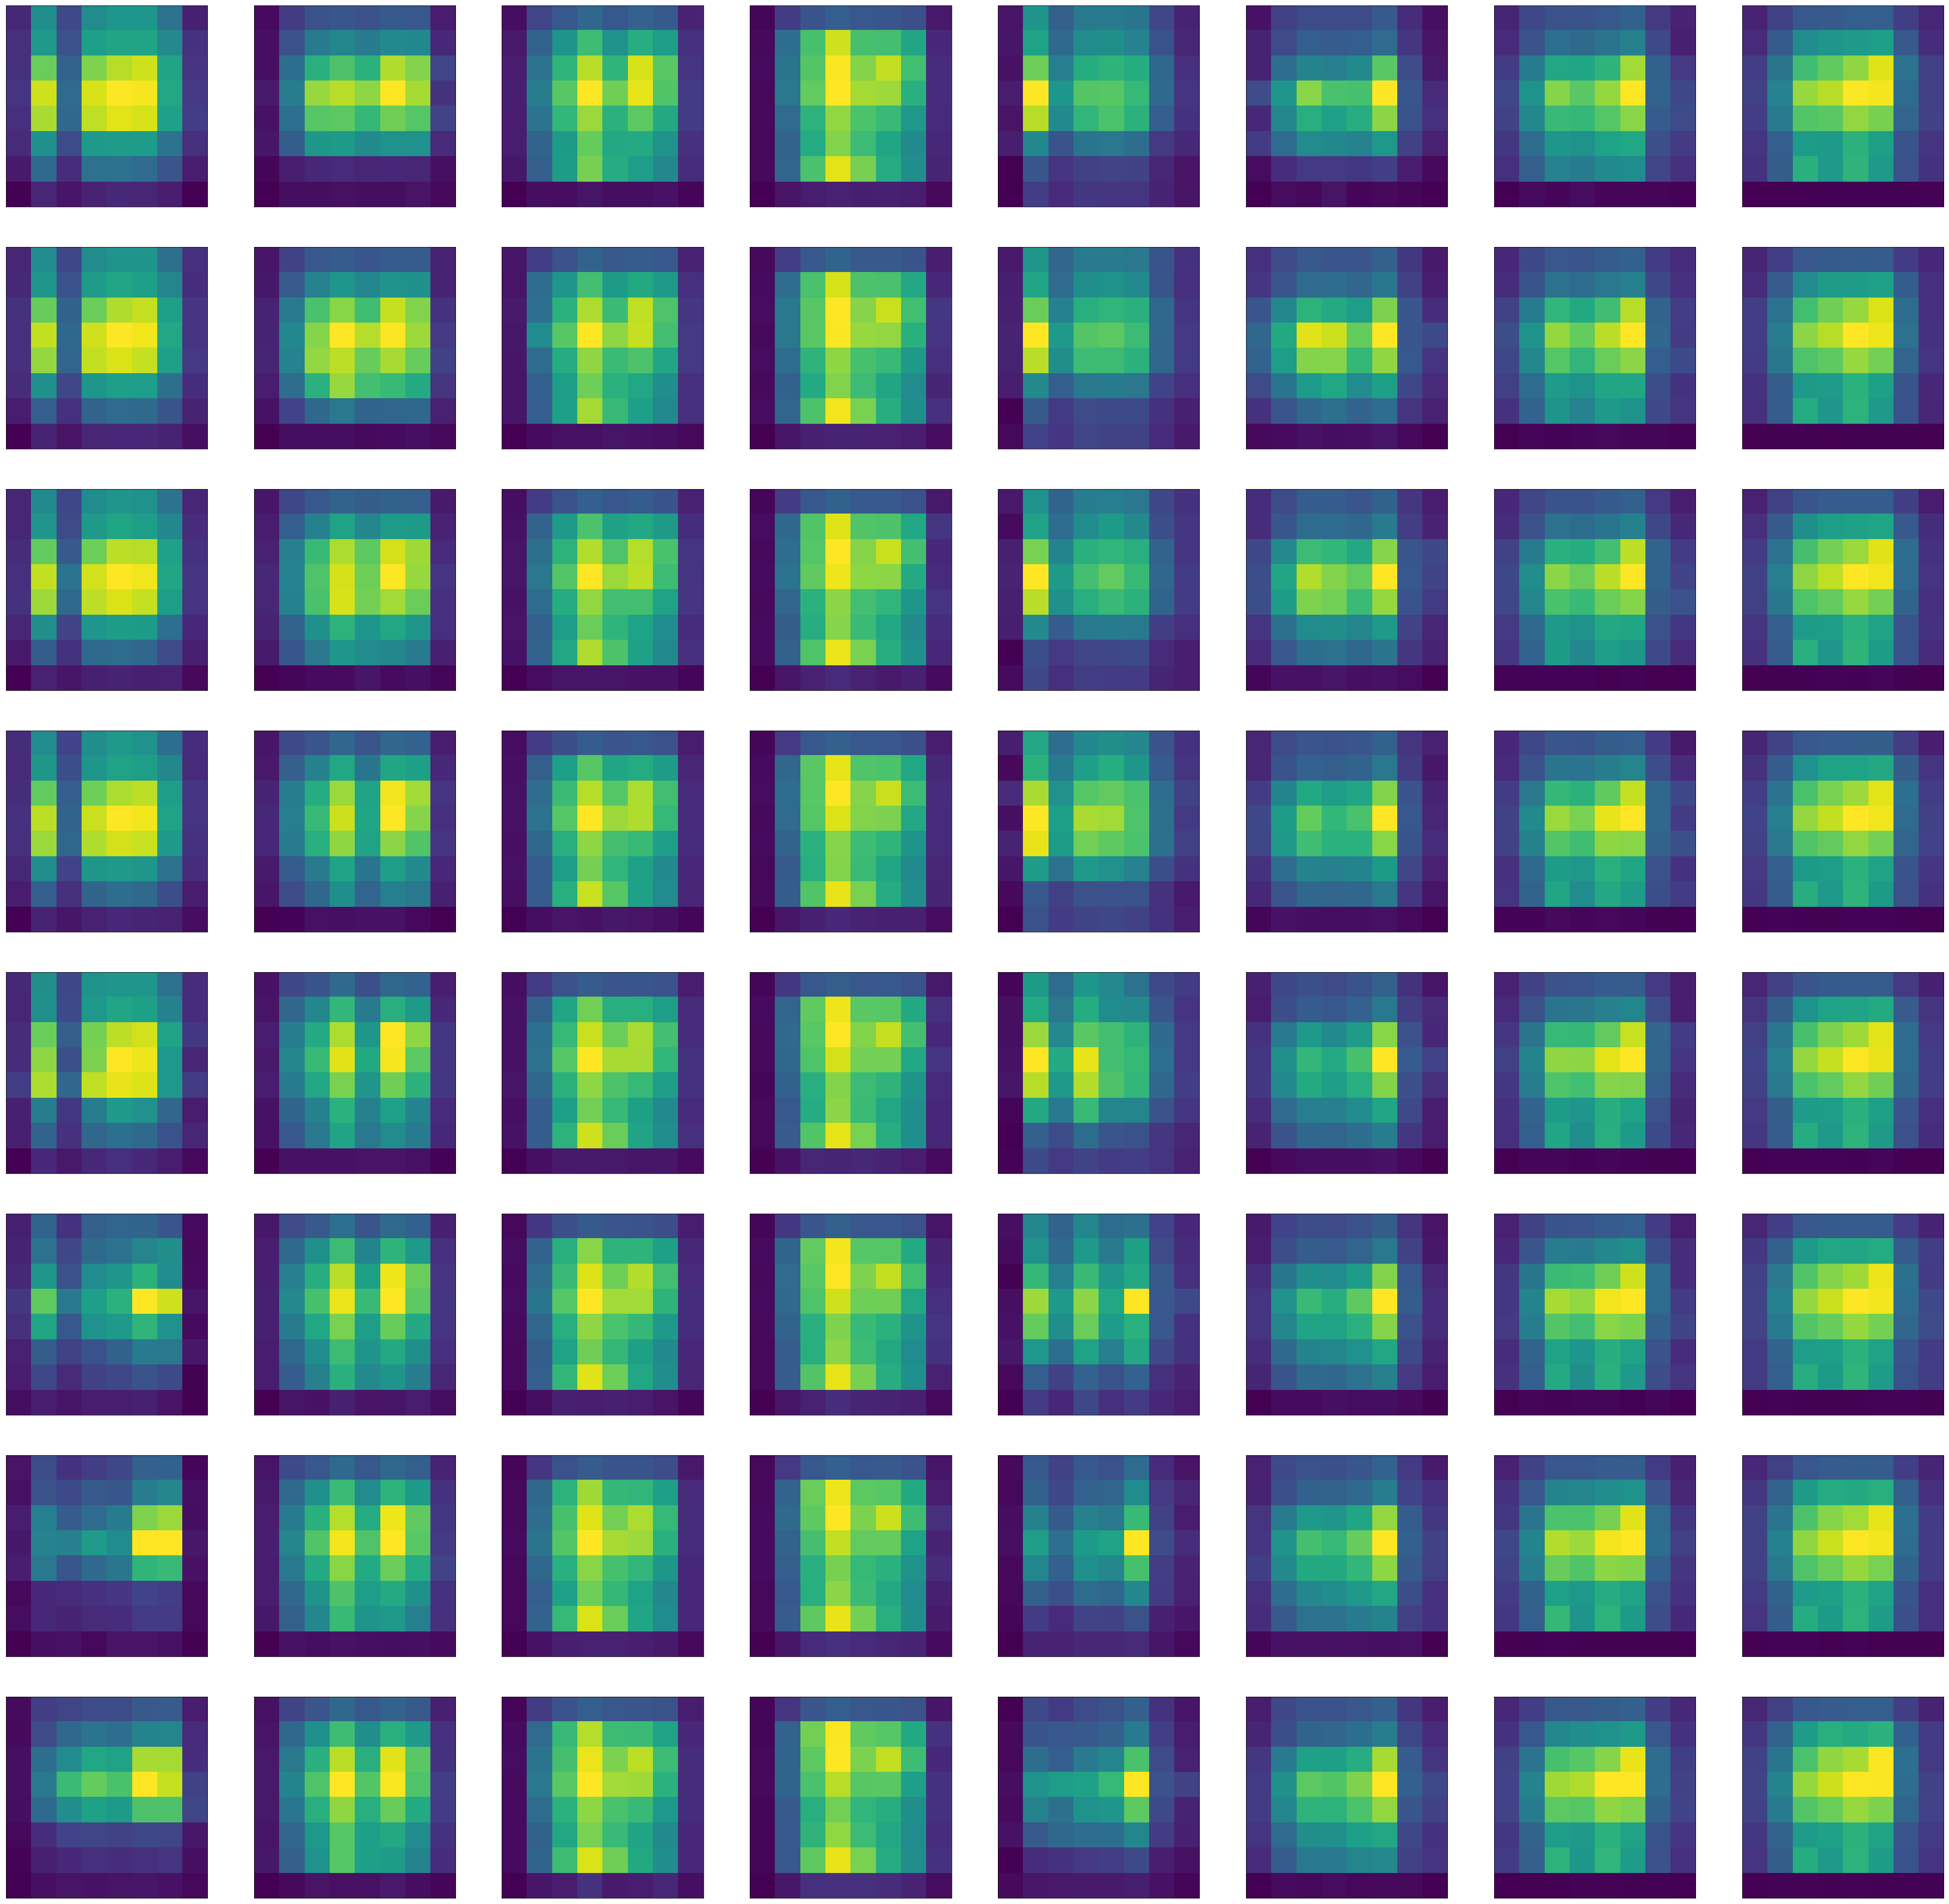

In [22]:
def show_images(data1,data2):
    n=8
    plt.figure(figsize=(20,4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        img = data1[0][i].reshape(8,8)
        plt.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i+1+n)
        newimg = data2[1][i].reshape(8,8)
        plt.imshow(newimg)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
def show(data1,data2):
    n=8
    plt.figure(figsize=(64, 64))
    k = 0
    l = 0
    for j in range(n):
        for i in range(n):
            ax = plt.subplot(8,8, j + 1 + 8*i)
            if k < 32:
                plt.imshow(data1[0][k].reshape(8,8))
                k += 1
            else:
                plt.imshow(data2[0][l].reshape(8,8))
                l += 1
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
    plt.show()
    
show(x_train,x_test)

In [29]:
input_img = Input(shape=(1747,64))

e = LSTM(32, return_sequences=True, activation='relu')(input_img)
e = LSTM(400, return_sequences=False, activation='relu')(e)
encoded = RepeatVector(1747)(e)

d = LSTM(32, return_sequences=True, activation='relu')(encoded)
d = LSTM(64, return_sequences=True, activation='relu')(d)
decoded = TimeDistributed(Dense(64))(d)

model = Model(input_img, decoded)
model.compile(optimizer='adadelta',loss='binary_crossentropy')
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 1747, 64)          0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 1747, 32)          12416     
_________________________________________________________________
lstm_43 (LSTM)               (None, 400)               692800    
_________________________________________________________________
repeat_vector_15 (RepeatVect (None, 1747, 400)         0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 1747, 32)          55424     
_________________________________________________________________
lstm_45 (LSTM)               (None, 1747, 64)          24832     
_________________________________________________________________
time_distributed_11 (TimeDis (None, 1747, 64)          416

In [43]:
input_img = Input(shape=(1747,8,8,1))

e = ConvLSTM2D(16,(3,3), return_sequences=True,padding='same')(input_img)
e = BatchNormalization()(e)
e = ConvLSTM2D(32, (3,3), return_sequences=False,padding='same')(e)
e = Flatten()(e)

d = RepeatVector(1747)(e)
d = Reshape((1747,8,8,32))(d)
d = ConvLSTM2D(16, (3,3), return_sequences=True, padding='same')(d)
d = ConvLSTM2D(1, (3,3), return_sequences=True, padding='same')(d)

model = Model(input_img, d)
model.compile(optimizer='adadelta',loss='binary_crossentropy')
model.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 1747, 8, 8, 1)     0         
_________________________________________________________________
conv_lst_m2d_38 (ConvLSTM2D) (None, 1747, 8, 8, 16)    9856      
_________________________________________________________________
batch_normalization_18 (Batc (None, 1747, 8, 8, 16)    64        
_________________________________________________________________
conv_lst_m2d_39 (ConvLSTM2D) (None, 8, 8, 32)          55424     
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
repeat_vector_19 (RepeatVect (None, 1747, 2048)        0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 1747, 8, 8, 32)    0  

In [86]:
input_img = Input(shape=(None,64))

e = LSTM(40, return_sequences=True)(input_img)
# e = RepeatVector(3)(e)
# e = BatchNormalization()(e)
# e = ConvLSTM2D(40, (3,3), return_sequences=False,padding='same')(e)
# e = BatchNormalization()(e)
# encoded = Conv2D(10, (3,3), activation='relu', padding='same', data_format='channels_last')(e)
encoded = TimeDistributed(Dense(1))(e)
'''
# d = Conv2DTranspose(40, (3,3), padding='same', activation='relu')(encoded)
# d = RepeatVector(5)(d)
d= Reshape((70, 45, 80, 40))(encoded)
d = ConvLSTM2D(40,(8,8),return_sequences=True,padding='same')(encoded)
d = BatchNormalization()(d)
decoded = ConvLSTM2D(None,(8,8),return_sequences=True,padding='same')(d)
decoded = TimeDistributed(Dense(8))'''




model = Model(input_img, encoded)
model.compile(optimizer='adadelta',loss='binary_crossentropy')
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        (None, None, 64)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 40)          16800     
_________________________________________________________________
time_distributed_10 (TimeDis (None, None, 1)           41        
Total params: 16,841
Trainable params: 16,841
Non-trainable params: 0
_________________________________________________________________


In [ ]:
encoder = Model(input_img, e4)
encoded_input = Input(shape=(45,80,8))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))


tbCallBack = TensorBoard(log_dir='./ConvLSTM', histogram_freq=0, write_graph=True, write_images=True)
#a.fit(...... , callbacks=tbCallBack)
autoencoder.fit(train,train, epochs=20, batch_size=32, 
                validation_data=(test,test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

encoded_imgs = encoder.predict(test)
decoded_imgs = decoder.predict(encoded_imgs)
decodedae = autoencoder.predict(test)